# MCQMC 2024 Kernel Density Estimation
### Fred J. Hickernell

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

### If you are running this on colab, run this cell below
### If you running this in Jupyter notebook and you have the environment set up, ignore this cell below

In [1]:
# If you are running this on colab, replace False by True

if False:  #Running on colab?
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !sudo apt install cm-super
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@MCQMC2024


### Import needed packages

In [37]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
import pandas as pd
from scipy import stats
from simple_colors import *
from copy import deepcopy
import sympy as sy
import sympy.stats
import pickle
#!pip install UniformSumDistribution
from UniformSumDistribution import UniformSumDistribution
figpath = 'MCQMC2024KDE/' #this path sends the figures to the directory that you want, make sure that it is created
savefigs = True  #save the figures on your disk if True
imgfrmt = 'pdf'
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  #get the color cycle
[py_blue, py_orange, py_green, py_red] = color_cycle[0:4]
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

## Set up sampling schemes

In [43]:
samplers = [{"gen_sample" : lambda d, n : qp.IIDStdUniform(d).gen_samples(n),
            "sample_name" : "IID"},
           {"gen_sample" : lambda d, n : qp.Sobol(d).gen_samples(n),
            "sample_name" : "Sobol' (LD)"},
           {"gen_sample" : lambda d, n : qp.Lattice(d).gen_samples(n),
            "sample_name" : "lattice"},          
           {"gen_sample" : lambda d, n : qp.Halton(d).gen_samples(n),
            "sample_name" : "Halton"}]

## Plot Grid, IID, and LD Points

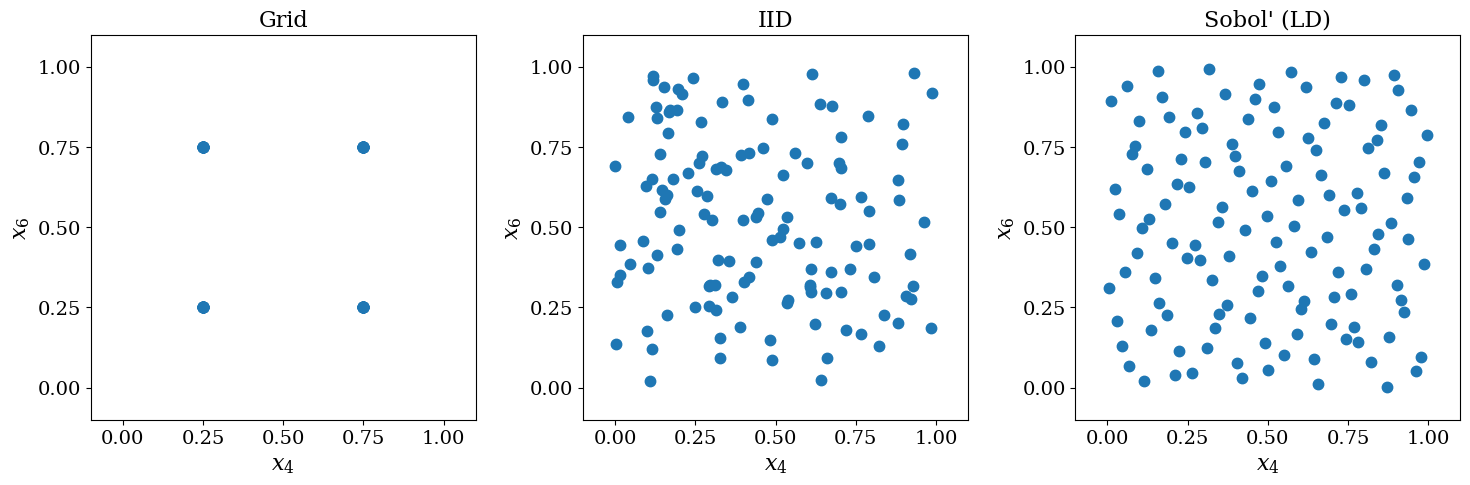

In [48]:
n = 128
d = 6
nper = np.floor(n**(1./d)).astype('int')
whcoord = np.array([3,5])

xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  #array of coordinate values
xgrid = xpts  #initial grid
nn = nper  #initial length of grid
for ii in range(1,d):
    xgrid0 = xgrid  #store the old grid
    xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,nn))))  #stack the next coordinate
    for jj in range(1,nper):
        xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,nn))))))
    nn = nn*nper  #update the length of the grid
xgrid = xgrid.T  #take the transpose to that coordinates are columns


fig, ax = plt.subplots(1,3,figsize = (18,5))
for ii in range(3):
    ax[ii].set_xlabel(f"${{x_{whcoord[0]+1}}}$",fontsize=16)
    ax[ii].set_ylabel(f"${{x_{whcoord[1]+1}}}$",fontsize=16)
    ax[ii].set_xlim([-0.1, 1.1])
    ax[ii].set_ylim([-0.1, 1.1])
    ax[ii].set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax[ii].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)

ax[0].plot(xgrid[:,whcoord[0]],xgrid[:,whcoord[1]],'.', markersize = 15)
ax[0].set_title('Grid', fontsize = 16)

for ii in range(2):
    #xIID = qp.IIDStdUniform(d, seed = 47).gen_samples(n)
    x = samplers[ii]["gen_sample"](d,n)
    ax[ii+1].plot(x[:,whcoord[0]],x[:,whcoord[1]],'.', markersize = 15)
    ax[ii+1].set_title(samplers[ii]["sample_name"], fontsize = 16)

if savefigs:
        fig.savefig(figpath+f"{n:.0f}PtComparison_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Set Up Functions of Uniform Random Variables and Their Densities

### A dictionary for each $f$

#### Weighted sum of Gaussians is a Gaussian

In [58]:
def sum_d_Gauss_case(restrict_domain = False): #Sum of Gaussian random variables
    '''
    restrict_domain is used if we want to restrict the sample space
    '''
    def fullwts(d = 1,coord_wts = 1):
        fw = coord_wts[:np.min([d,coord_wts.shape[0]])] * np.ones(d) #expand the weights to fit the dimension
        stdev = np.sqrt(np.sum(fw**2))  #square root of sum of squares of weights
        return fw, stdev
    def f(x,d = 1,coord_wts = 1): 
        assert x.ndim > 1
        return np.sum(sp.stats.norm.ppf(x) * fullwts(d,coord_wts)[0], axis = -1)
    def gprime(x,yeval,d = 2,coord_wts = 1): 
        assert d >= 2
        fw1 = fullwts(d,coord_wts)[0][0]
        n_y = yeval.size
        n_x = x.shape[0]
        return sp.stats.norm.pdf((yeval.reshape(1,n_y) - f(x[:,:d-1],d-1,coord_wts[1:d]).reshape(n_x,1)/fw1))/fw1    
    def density(y,d = 1,coord_wts = 1):
        return sp.stats.norm.pdf(y, scale = fullwts(d,coord_wts)[1])
    return  { #return a dictionary with
        "f" : f,       #the function f that defines Y = f(X) for X Uniform on [0,1]^d
        "gprime" : gprime,   #the function g' used for conditional Monte Carlo
        "density" : density,  #probability density of f(X) where X is IID U([0,1]^d)
        "y_plt_domain" : lambda d,coord_wts : np.array([-3.,3.])*fullwts(d,coord_wts)[1],  #domain for plotting the density
        "y_domain" : lambda d, coord_wts : np.array([-np.inf,np.inf]),  #sample space of Y = f(X)
        "name" : lambda d,coord_wts : f"Weighted Sum of {d:.0f} Gaussians",  #Plot label for density
        "d_allowed" : [float('inf')]
        }

#### Sum of uniforms is an [Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin–Hall_distribution)

In [59]:
def sum_d_unif_case(restrict_domain = False): #Sum of uniform random variables
    '''
    restrict_domain is used if we want to restrict the sample space
    '''
    def f(x,d = 1,coord_wts = 1):
        assert x.ndim > 1
        return x.sum(axis = -1)
    def gprime(x,yeval,d = 2,coord_wts = 1): 
        n_y = yeval.size
        n_x = x.shape[0]
        yminusf = yeval.reshape(1,n_y) - f(x[:,:d-1],d-1,coord_wts[1:d]).reshape(n_x,1)
        return ((yminusf >= 0) & (yminusf <= 1)).astype(float)    
    def density(y,d = 1,coord_wts = 1):
        return UniformSumDistribution(d).pdf(y)
    def y_domain(d, coord_wts):
        if restrict_domain:
            return np.array([0,d])
        else:
            return np.array([-np.inf,np.inf])
    return {"f" : f,       #return a dictionary
            "gprime" : gprime,   #the function g' used for conditional Monte Carlo
            "density" : density,  #probability density of f(X) where X is IID U([0,1]^d)
            "y_plt_domain" : lambda d,coord_wts : np.array([-0.1,d+0.1]),  #domain for plotting the density
            "y_domain" : y_domain,  #sample space of Y = f(X)
            "name" : lambda d,coord_wts : f"Sum of {d:.0f} uniforms",  #Plot label for density
            "d_allowed" : [float('inf')]
    }

#### Put the cases together

In [60]:
ex_densities = [sum_d_unif_case(False),sum_d_Gauss_case()]
#ex_densities = [sum_d_unif_case()]
dens_kwargs = {"d" : 5, "coord_wts" : np.array(range(1,11))**-1.}

## Density estimation routines

### Define a kernel density estimator (KDE)

In [61]:
def kernel_val(ydata, yeval = np.array([0]), 
          kernel = {"name" : "Gauss", "bandwidth" : 1, "domain" : np.array([-np.inf, np.inf])}):  #a kernel for kernel density estimation(KDE)
    '''
        kernel = the choice of kernel
        ydata = the observations of Y used to construct the KDE
        yeval = the values of y where the density is to be approximated
        bandwidth = the bandwidth of the kernel
        domain = (a,b) = sample space of Y
    '''
    h = kernel["bandwidth"]
    a = kernel["domain"][0]
    b = kernel["domain"][1]
    n_data = len(ydata)
    n_eval = len(yeval)
    if kernel["name"] == "Gauss":
        '''
        kernel = exp(-y**2)/sqrt(pi)
        integral = (erf(b) - erf(a))/2        
        '''
        ydata = ydata.reshape(n_data,1)
        yeval = yeval.reshape(1,n_eval)
        k_val = np.exp(-((ydata - yeval)/h)**2)/(h*np.sqrt(np.pi))
        k_val /= (sp.special.erf((b-ydata)/h) - sp.special.erf((a-ydata)/h))/2   #correction to the kernel for the restricted sample space
        k_val *= ((yeval >= a) & (yeval <= b))  #restrict to domain
        kde_val = np.mean(k_val,axis = 0)
        #print(domain_window)
    elif kernel["name"] == "HermiteTwo":
        '''
        kernel = (-2*y**2 + 3)*exp(-y**2)/(2*sqrt(pi))
        integral =  -(a*exp(-a**2)/2 + sqrt(pi)*erf(a)/2)/sqrt(pi) + (b*exp(-b**2)/2 + sqrt(pi)*erf(b)/2)/sqrt(pi)
        '''
        yarg = (ydata.reshape(n_data,1) - yeval.reshape(1,n_eval))/h
        k_val = (-2*yarg**2 + 3) * np.exp(-yarg**2)/(h*2*np.sqrt(np.pi))
        #print(domain_window)
    else:
        print("Kernel not recognized")
    return k_val

In [62]:
def kde(ydata, yeval = np.array([0]), 
          kernel = {"name" : "Gauss", "bandwidth" : 1, "domain" : np.array([-np.inf, np.inf])}):  #a kernel for kernel density estimation(KDE)
    '''
        kernel = the choice of kernel
        ydata = the observations of Y used to construct the KDE
        yeval = the values of y where the density is to be approximated
        bandwidth = the bandwidth of the kernel
        domain = (a,b) = sample space of Y
    '''
    k_val = kernel_val(ydata, yeval, kernel)
    return np.mean(k_val,axis = 0)

### Define a conditional Monte Carlo density estimator

In [63]:
def cmc(gprime, xdata, yeval = np.array([0]),**dens_kwargs):
    cmc_est = np.mean(gprime(xdata,yeval,**dens_kwargs), axis = 0)
    #print("yeval shape =",yeval.shape)
    #print("xdata shape =",xdata.shape)
    #print("cmc shape =",cmc_est.shape)
    return np.mean(gprime(xdata,yeval,**dens_kwargs), axis = 0)

### Choosing the best error out of different bandwidths

In [64]:
def error_rho(rhoexact,rhoapp,h_list,kind_of_err = ["rmse"]):  #Compute different error measures for the KDE
    err_out = dict.fromkeys(kind_of_err)
    ''' 
    In this dictionary output
                          key = kind of error measure
        0th entry in the list = where the best bandwidth occurs
        1st entry in the list = best bandwidth
        2nd entry in the list = best error
        rest of the entries   = errors of all bandwidths
    '''
    err_rho = rhoexact - rhoapp  #pointwise error
    n_h = h_list.shape[0]
    #print("n_h =",n_h)
    if "rmse" in kind_of_err:  #root mean squared error                           
        rmse = np.sqrt((err_rho**2).mean(1))
        where_min = rmse.argmin()
        err_out["rmse"] = [where_min, h_list[where_min], rmse[where_min], *rmse]
    if "mae" in kind_of_err:  #mean absolute error
        mae = np.abs(err_rho).mean(-1)
        if n_h > 1:
            where_min = mae.argmin()
            err_out["mae"] = [where_min, h_list[where_min], mae[where_min], *mae]
        else:
            err_out["mae"] = [0, h_list[0], mae, mae]
            #print("err_out = ",err_out)
    if "sup" in kind_of_err:  #supremum or maximum of error
        sup = np.abs(err_rho).max(1)
        where_min = sup.argmin()
        err_out["sup"] = [where_min, h_list[where_min], maxe[where_min], *sup]    
    return err_out

## A small experiment

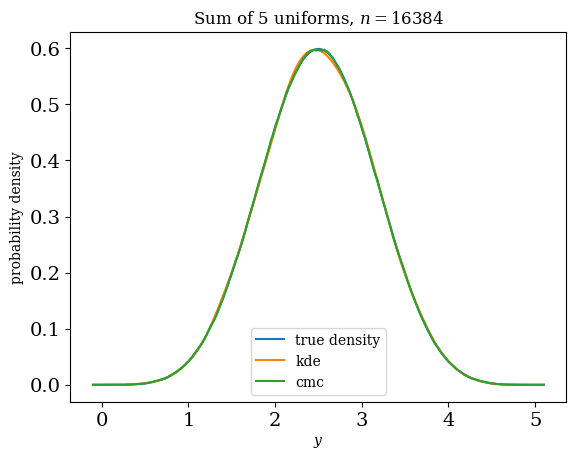

In [65]:
n = 2**14
d = 5
wh_sampler = 1
wh_dens = 0
ex_dens = ex_densities[wh_dens]
x = samplers[wh_sampler]["gen_sample"](d,n)

nplot = 500 #number of points to plot the KDE at
wh_err = "mae"
dens_kwargs = {"d" : d, "coord_wts" : np.array(range(1,11))**-1.}
bandwidth = np.array([0.05])

plt_domain = ex_dens["y_plt_domain"](**dens_kwargs) 
the_y_domain = ex_dens["y_domain"](**dens_kwargs)
yplot = np.linspace(plt_domain[0],plt_domain[1],nplot)
rhoexact = ex_dens["density"](yplot,**dens_kwargs)
h = np.diff(plt_domain)[0]*bandwidth
#kernel = {"name" : "Gauss", "bandwidth" : h, "domain" : y_domain}
kernel = {"name" : "HermiteTwo", "bandwidth" : h, "domain" : the_y_domain}
f = ex_dens["f"]
ypts = f(x,**dens_kwargs)  #construct all data points for all repetitions
rhoapp_kde = kde(ypts,yplot,kernel)  #kde estimate
err_kde = error_rho(rhoexact,rhoapp_kde,h,kind_of_err = [wh_err])  #find error
rhoapp_cmc = cmc(ex_dens["gprime"],x,yplot,**dens_kwargs)  #cmc estimate
err_cmc = error_rho(rhoexact,rhoapp_cmc,h,kind_of_err = [wh_err])  #find error
fig,ax = plt.subplots()
ax.plot(yplot, rhoexact, label = "true density")
ax.set_title(f'{ex_dens["name"](**dens_kwargs):s}, $n = {n:.0f}$')
ax.set_xlabel("$y$")
ax.set_ylabel("probability density")  
ax.plot(yplot,rhoapp_kde, label = 'kde')
ax.plot(yplot,rhoapp_cmc, label = 'cmc')
ax.legend(loc="lower center");

## Plot results of experiments

### Plotting functions

In [ ]:
def plot_kde_densities(kernel_name,wh_err,ex_densities,n_list,dim_list,yplot,rhoexact, \
                   kde_rhoapp,kde_pp_wh_med,kde_best_err):    #this function plots the densities and their KDE approximations
    n_densities = len(ex_densities)  #number of cases of f and densities
    n_samplers = len(samplers)  #number of samplers
    n_dim = dim_list.shape[0]  #number of dimensions
    n_n = n_list.shape[0]  #number of sample sizes                   
    for ll in range(n_n):
        n = n_list[ll]
        for ii in range(n_densities):  #iterate over different f and corresponding densities
            fig,ax = plt.subplots(1,n_dim,figsize = (18,5))
            for kk in range(n_dim):  #iterate over different dimensions
                d = dim_list[kk]
                dens_kwargs["d"] = d
                if (ex_densities[ii]["d_allowed"] == [float('inf')]) or any(d == dd for dd in ex_densities[ii]["d_allowed"]):
                    ax[kk].plot(yplot[ii,kk,:], rhoexact[ii,kk,:], label = "true density")
                    ax[kk].set_title(f'{ex_densities[ii]["name"](**dens_kwargs):s}, $n = {n:.0f}$')
                    ax[kk].set_xlabel("$y$")
                    ax[kk].set_ylabel("probability density")  
                    for jj in range(n_samplers):  #iterate over different sampling methods
                        pp_plot = kde_pp_wh_med[ii,jj,kk,ll]
                        ax[kk].plot(yplot[ii,kk,:],kde_rhoapp[ii,jj,kk,ll,:], 
                                label = f'{samplers[jj]["sample_name"]}, {wh_err:s} = {kde_best_err[ii,jj,kk,ll]:0.1e}')
                    ax[kk].legend(loc="lower center")
            figfilename = f'KDE_Ex_{kernel_name}_Data_{wh_err}_rhoapp_{ex_densities[ii]["name"](**dens_kwargs):s}_nrep_{n_rep:.0f}_n_{n:.0f}_dmax_{d_max:.0f}.{imgfrmt:s}'
            fig.savefig(figpath+figfilename,format=imgfrmt,bbox_inches='tight')

In [ ]:
def plot_kde_error_n(kernel_name,wh_err,ex_densities,n_list,dim_list,kde_best_err,n_lim,err_lim):    #this function plots errors vs. the sample size
    n_densities = len(ex_densities)  #number of cases of f and densities
    n_samplers = len(samplers)  #number of samplers
    n_dim = dim_list.shape[0]  #number of dimensions
    n_n = n_list.shape[0]  #number of sample sizes
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  #get the color cycle
    for ii in range(n_densities):  #iterate over different f and corresponding densities
        fig,ax = plt.subplots(1,n_dim,figsize = (18,5))
        for kk in range(n_dim):  #iterate over different dimensions
            d = dim_list[kk]
            dens_kwargs["d"] = d
            if (ex_densities[ii]["d_allowed"] == [float('inf')]) or any(d == dd for dd in ex_densities[ii]["d_allowed"]):
                ax[kk].set_title(f'{ex_densities[ii]["name"](**dens_kwargs):s}, $n = {n:.0f}$')
                ax[kk].set_xlabel("$n$")
                ax[kk].set_ylabel(wh_err)  
                for jj in range(n_samplers):  #iterate over different sampling methods
                    ax[kk].loglog(n_list,kde_best_err[ii,jj,kk,:], '.', color = color_cycle[jj+1],
                            label = f'{samplers[jj]["sample_name"]}', )
                ax[kk].legend(loc="lower left")
                ax[kk].set_xlim(n_lim)
                ax[kk].set_ylim(err_lim)
        plt.show()
        figfilename = f'KDE_Ex_{kernel_name}_Data_{wh_err}_err_vs_n_{ex_densities[ii]["name"](**dens_kwargs):s}_nrep_{n_rep:.0f}_n_{n:.0f}_dmax_{d_max:.0f}.{imgfrmt:s}'
        fig.savefig(figpath+figfilename,format=imgfrmt,bbox_inches='tight')

In [ ]:
def plot_kde_h_n(kernel_name,wh_err,ex_densities,n_list,dim_list,kde_err_out_dict,n_lim,err_lim):    #this function plots bandwidths vs. the sample size
    n_densities = len(ex_densities)  #number of cases of f and densities
    n_samplers = len(samplers)  #number of samplers
    n_dim = dim_list.shape[0]  #number of dimensions
    n_n = n_list.shape[0]  #number of sample sizes    
    h_list = np.zeros(n_n)
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  #get the color cycle
    for ii in range(n_densities):  #iterate over different f and corresponding densities
        fig,ax = plt.subplots(1,n_dim,figsize = (18,5))
        for kk in range(n_dim):  #iterate over different dimensions
            d = dim_list[kk]
            dens_kwargs["d"] = d
            if (ex_densities[ii]["d_allowed"] == [float('inf')]) or any(d == dd for dd in ex_densities[ii]["d_allowed"]):
                ax[kk].set_title(f'{ex_densities[ii]["name"](**dens_kwargs):s}, $n = {n:.0f}$')
                ax[kk].set_xlabel("$n$")
                ax[kk].set_ylabel("$h$")  
                for jj in range(n_samplers):  #iterate over different sampling methods
                    for ll in range(n_n):
                        h_list[ll] = kde_err_out_dict[ii,jj,kk,ll][wh_err][1]
                    ax[kk].loglog(n_list,h_list, '.', color = color_cycle[jj+1],
                            label = f'{samplers[jj]["sample_name"]}', )
                ax[kk].legend(loc="lower left")
                ax[kk].set_xlim(n_lim)
                ax[kk].set_ylim(h_lim)
        figfilename = f'KDE_Ex_{kernel_name}_Data_{wh_err}_h_vs_n_{ex_densities[ii]["name"](**dens_kwargs):s}_nrep_{n_rep:.0f}_n_{n:.0f}_dmax_{d_max:.0f}.{imgfrmt:s}'
        fig.savefig(figpath+figfilename,format=imgfrmt,bbox_inches='tight')

In [ ]:
def plot_kernels(kernel_list,h_list,yplot,ycenter = np.array([0])):
    n_kernel = len(kernel_list)
    n_h = len(h_list)
    kernel = {"name" : "Gauss", "bandwidth" : 1, "domain" : np.array([yplot[0],yplot[-1]])}
    for ii, kernel_name in enumerate(kernel_list):
        fig, ax = plt.subplots(1,n_h,figsize = (18,5))
        kernel["name"] = kernel_name
        for jj,h in enumerate(h_list):
            kernel["bandwidth"] = h
            ax[jj].plot(yplot,kernel_val(yplot,ycenter,kernel))
            ax[jj].set_xlabel("$y$")
            ax[jj].set_ylabel(f"$\\tilde{{k}}(y/h)/h$,{'  ':s} $h = ${h:.1f}")  
            ax[jj].set_ylim([-0.4,3])
            ax[jj].set_title(f"{kernel_name:s} kernel")
        figfilename = f'{kernel_name:s}.{imgfrmt:s}'
        fig.savefig(figpath+figfilename,format=imgfrmt,bbox_inches='tight')

yplot = np.linspace(-3,3,500)
plot_kernels(["Gauss","HermiteTwo"],[0.2,0.5,1],yplot)

### Remember to load the data saved in the cells below to plot

In [76]:
wh_err = "mae"
kernel_name = "HermiteTwo"

experiment_size = "large"
if experiment_size == "small":
    #small experiment
    n_rep = 5 #number of replications
    n_list = 2**np.arange(6,10,dtype=int)
else:
    #large experiment
    n_rep = 15 #number of replications
    n_list = 2**np.arange(7,15,dtype=int) #list of sample sizes

d_max = 5
out_filename = f'KDE_Ex_Data_{wh_err:s}_{kernel_name:s}_nrep_{n_rep:.0f}_nmax_{n_max:.0f}_dmax_{d_max:.0f}.pkl'
with open(figpath+out_filename,'rb') as myfile: 
    wh_err,n_densities,n_dim,n_samplers,n_n,dim_list,n_list,yplot,rhoexact, \
                 kde_rhoapp,kde_err_out_dict,kde_pp_wh_med, kde_best_err, \
                 cmc_rhoapp,cmc_err_out_dict,cmc_pp_wh_med, cmc_best_err \
                 = pickle.load(myfile) #load in all the data

### Plot densities and their approximations

#### Plots of kernel density estimates

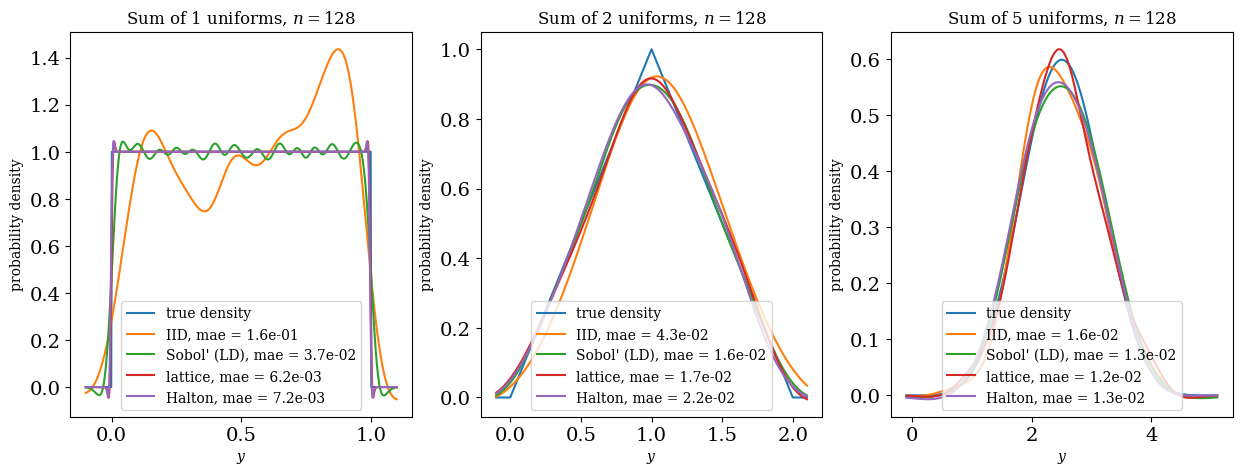

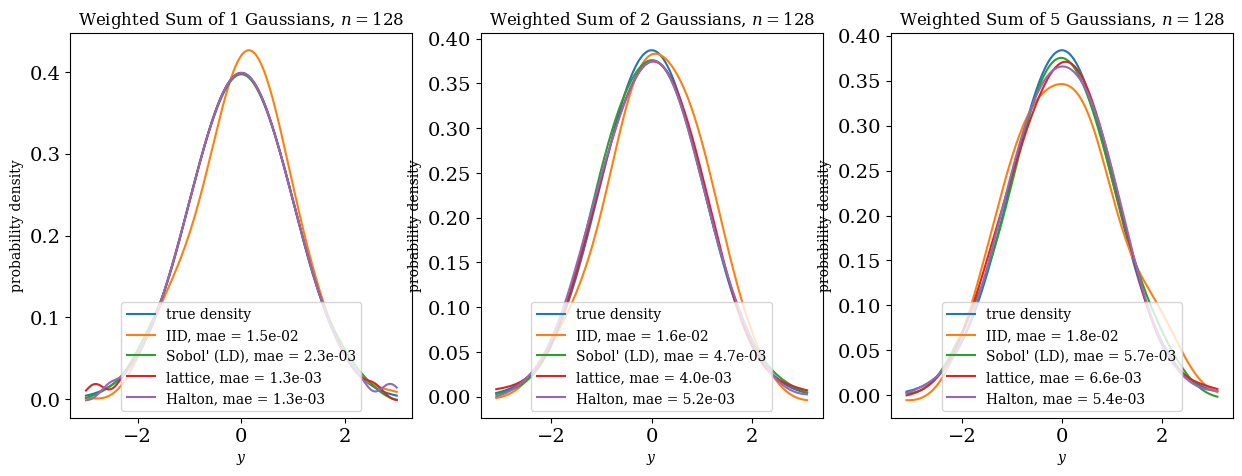

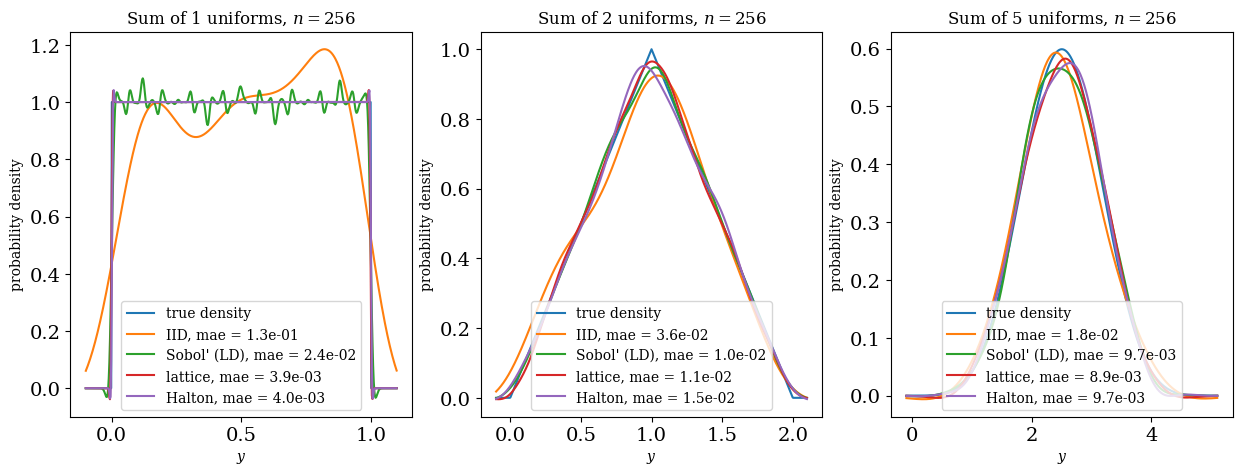

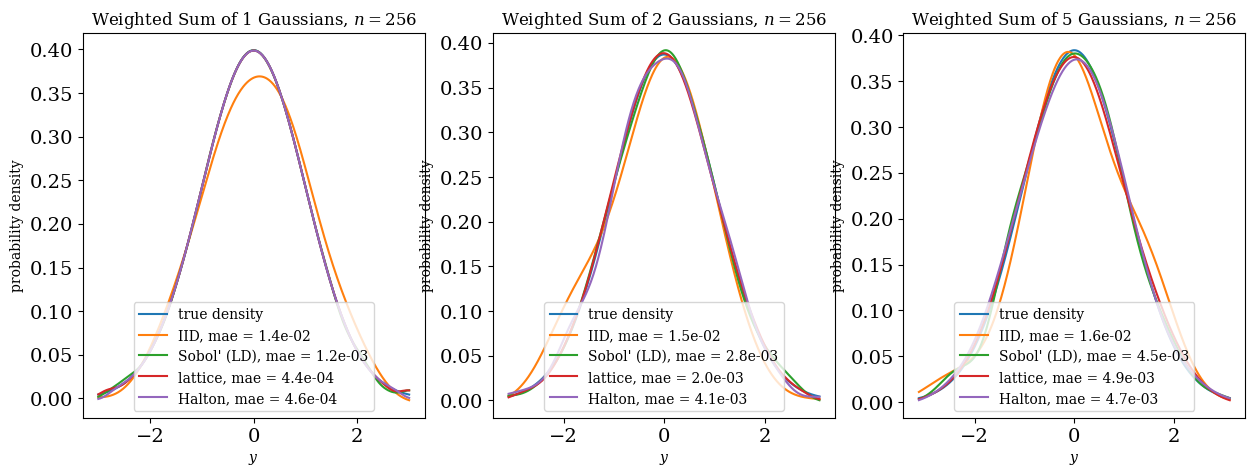

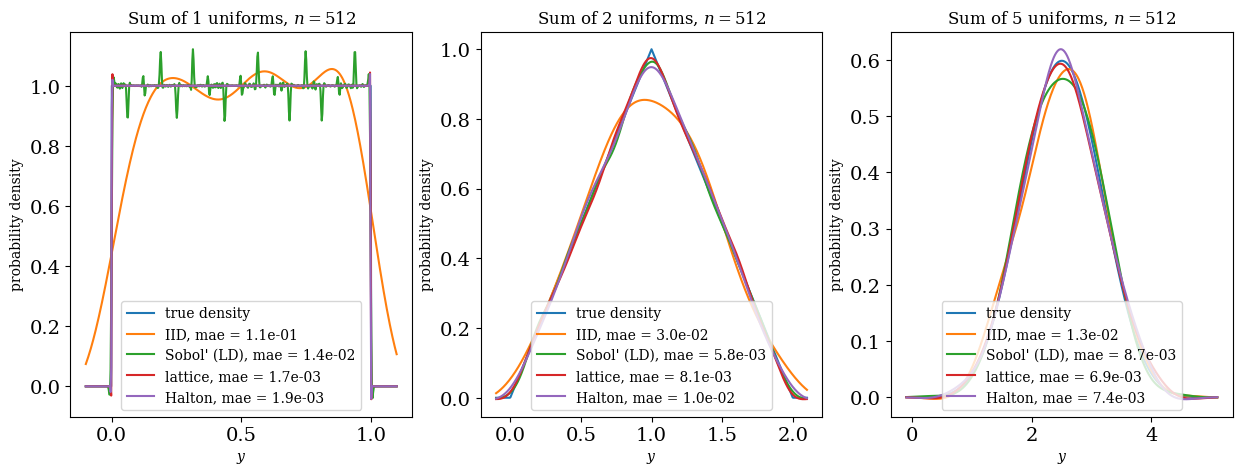

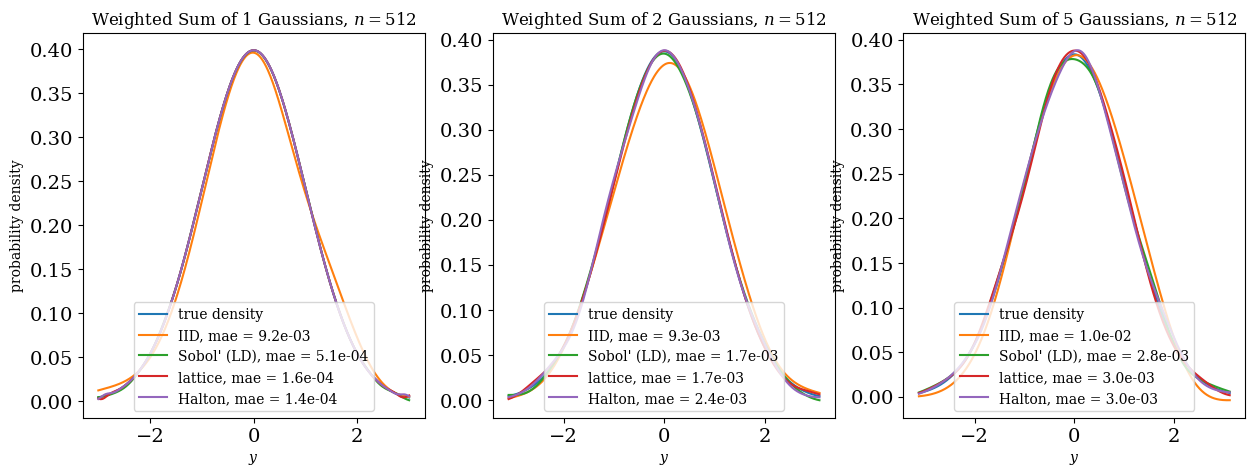

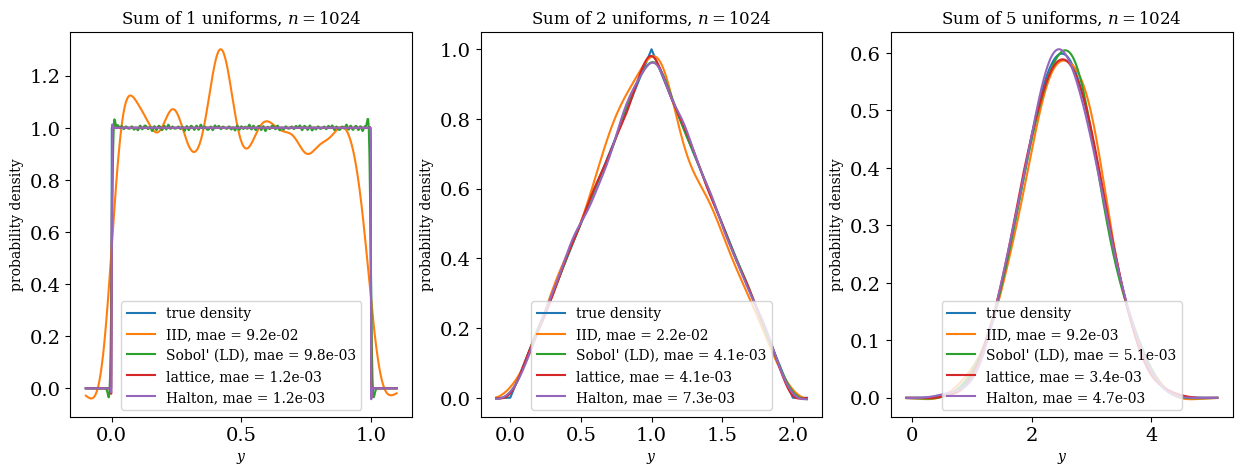

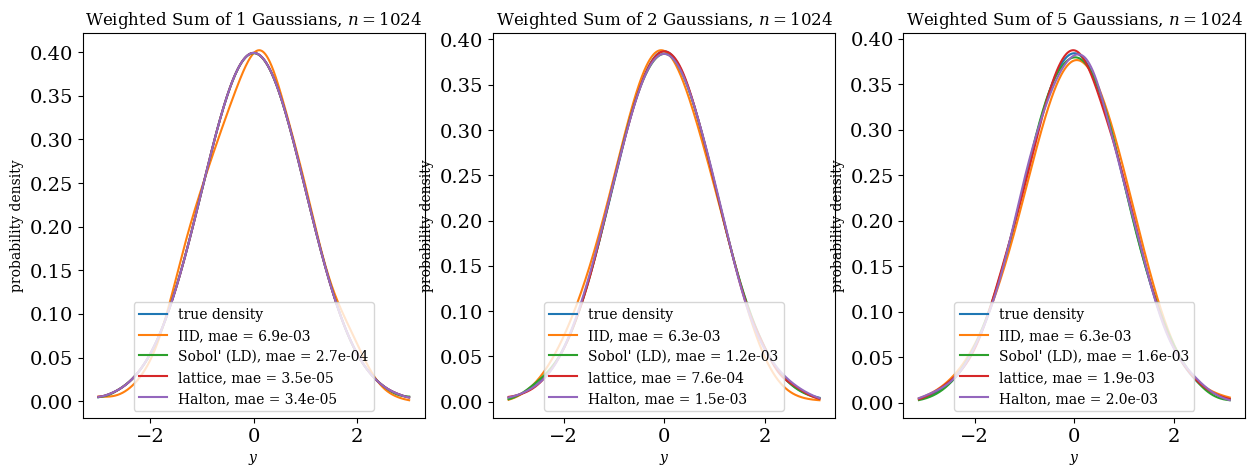

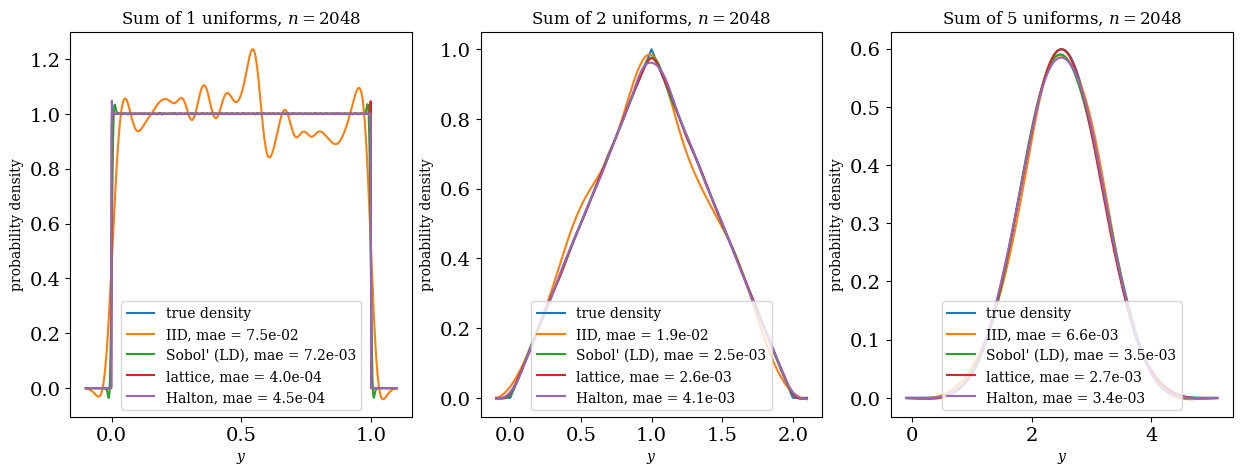

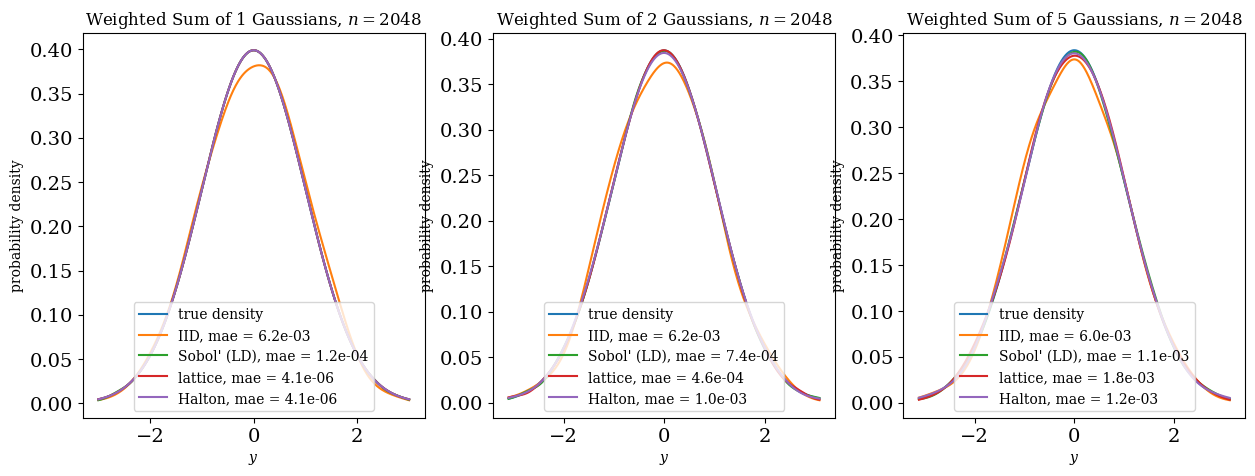

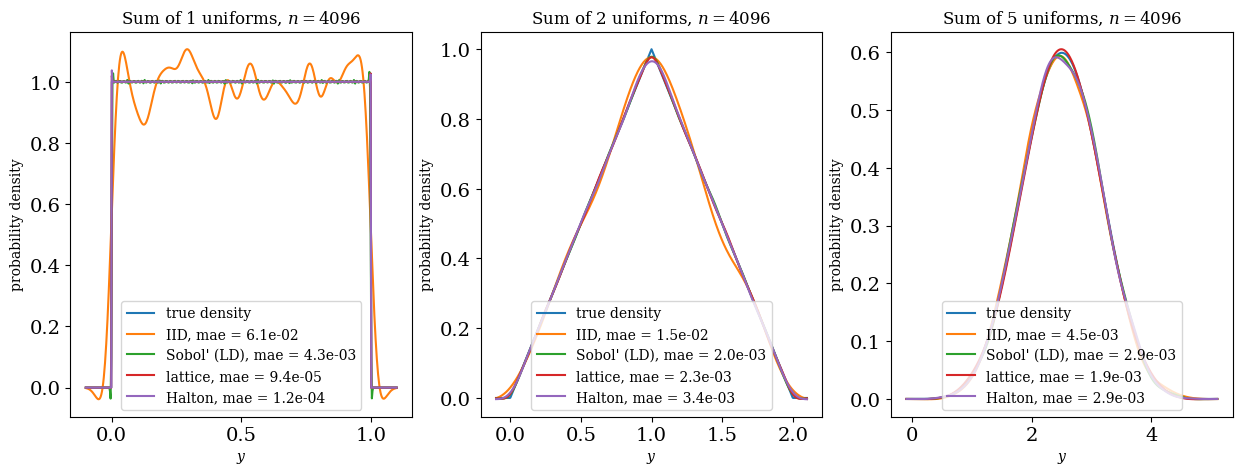

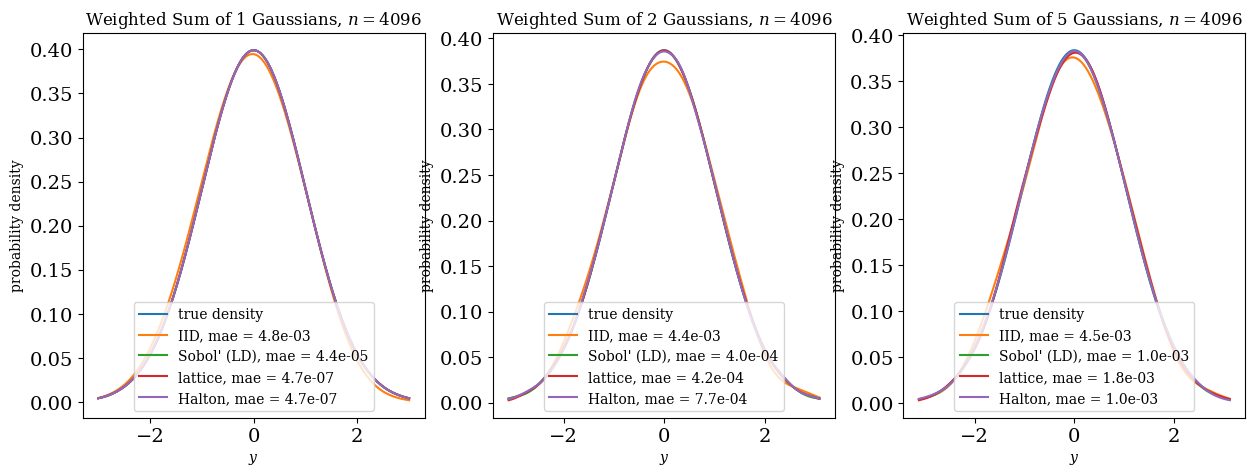

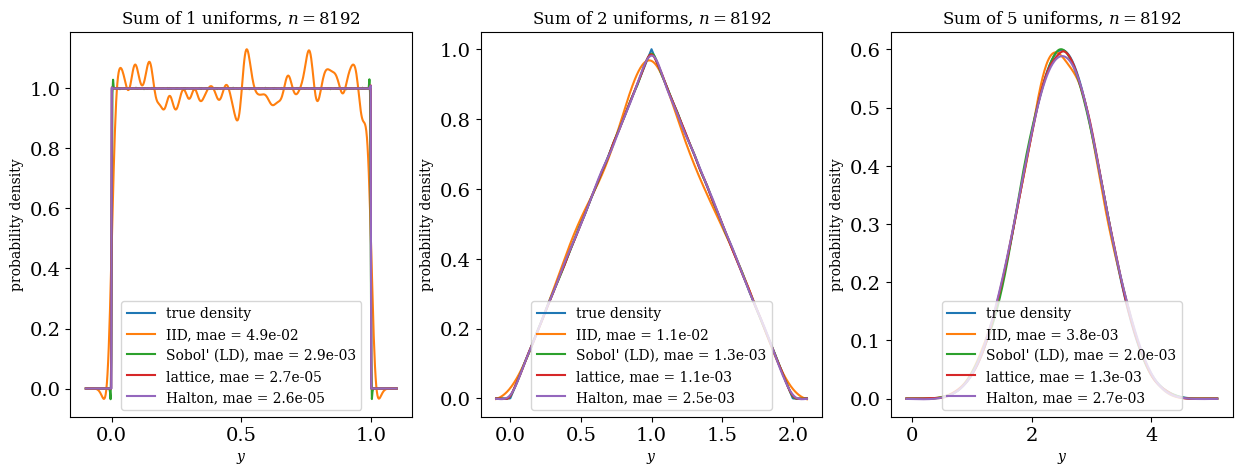

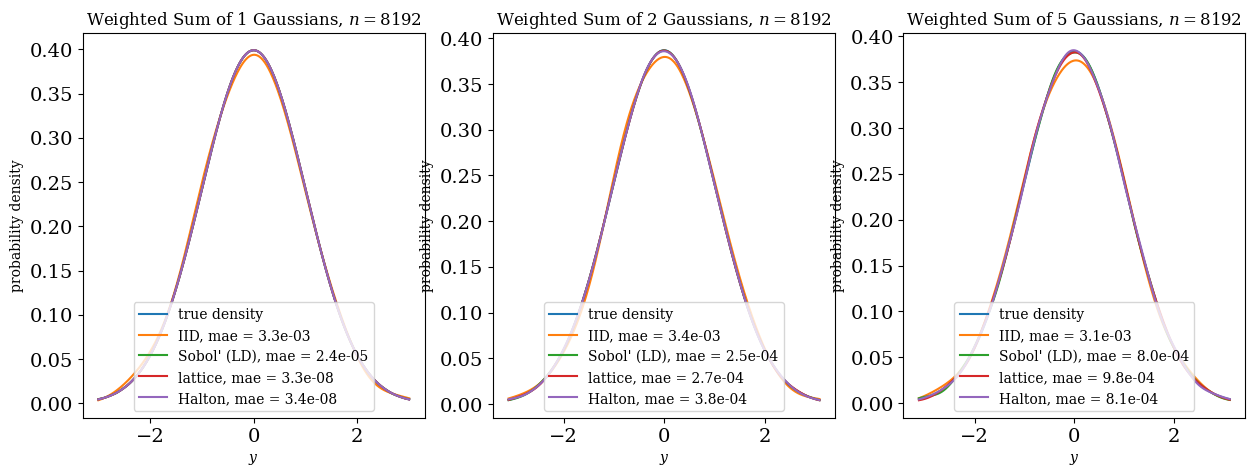

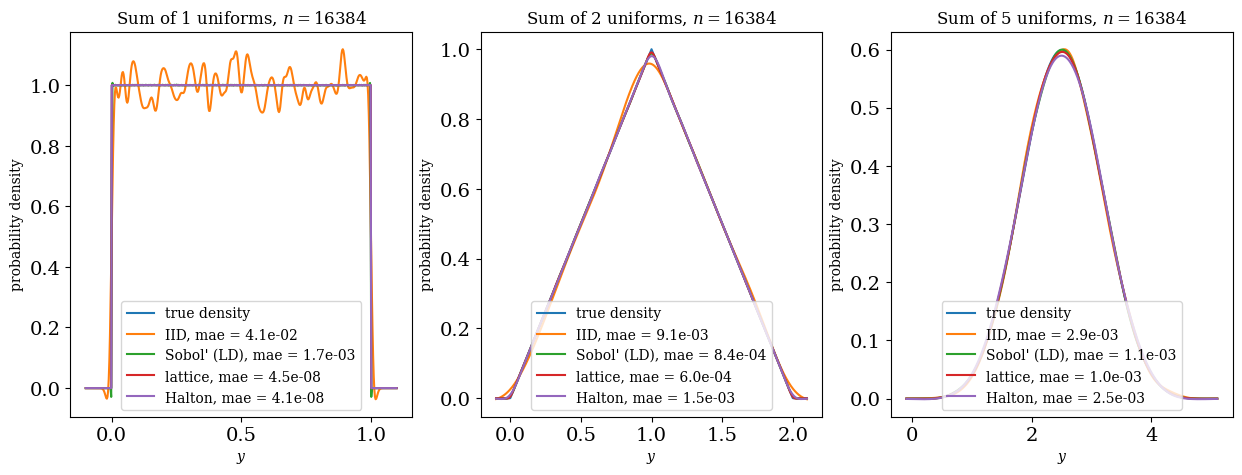

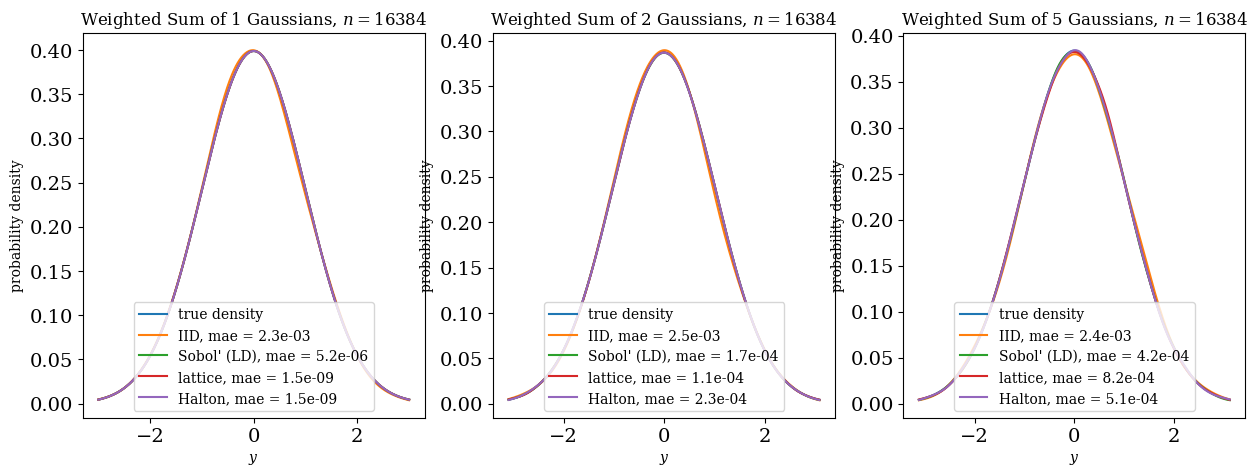

In [81]:
plot_kde_densities(kernel_name,wh_err,ex_densities,n_list,dim_list,yplot,rhoexact, \
                   kde_rhoapp,kde_pp_wh_med,kde_best_err)   ##plot the kde densitives vs the true density

#### Plot error vs. n

kde_best_err[0,2,0,-1] = 4.450732412220225e-08


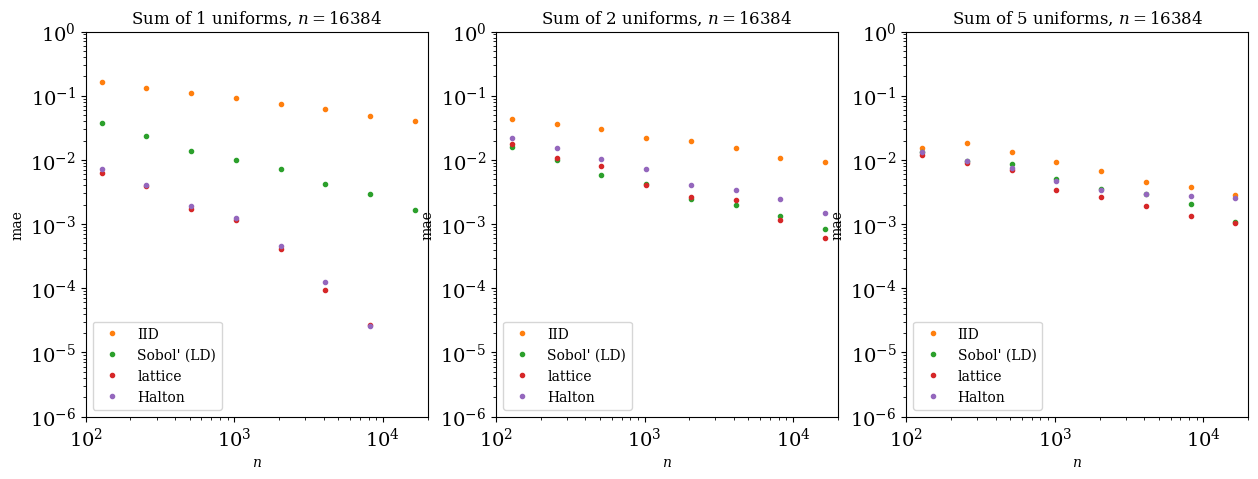

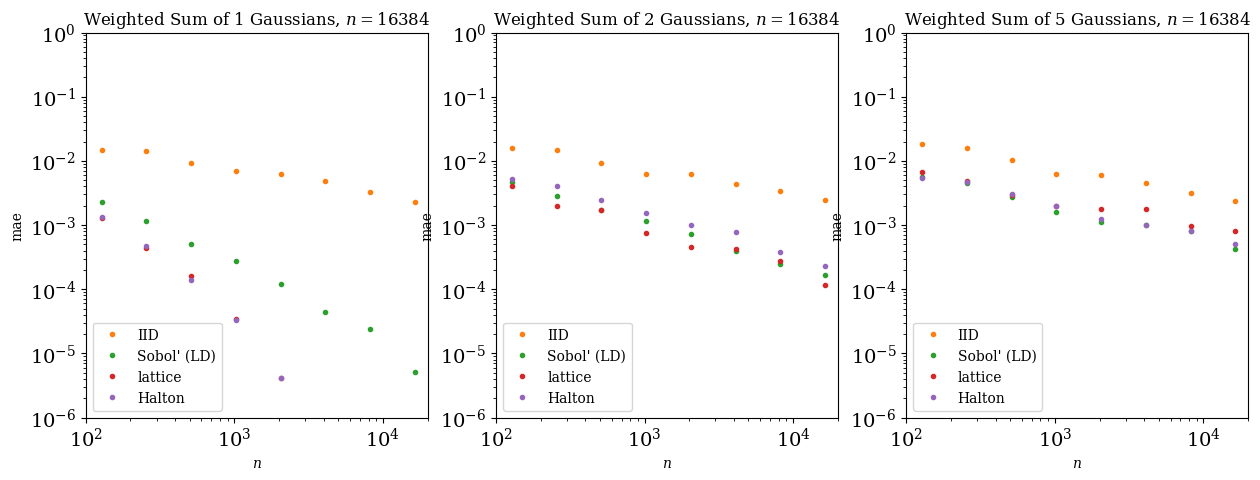

In [82]:
n_lim = [100,20000]
err_lim = [1e-6,1]
print("kde_best_err[0,2,0,-1] =",kde_best_err[0,2,0,-1])
plot_kde_error_n(kernel_name,wh_err,ex_densities,n_list,dim_list,kde_best_err,n_lim,err_lim)

#### Plot h vs. n

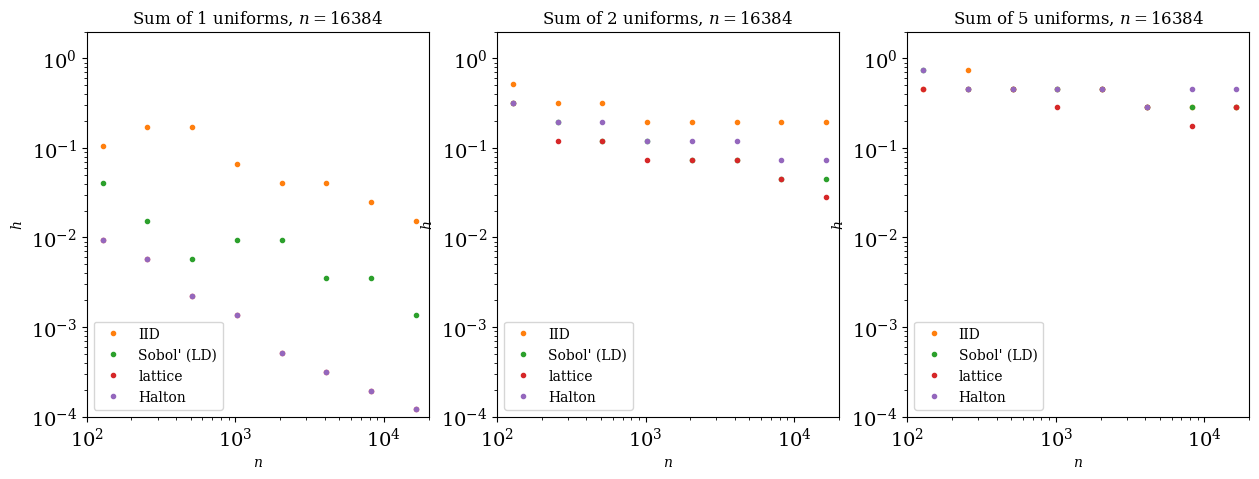

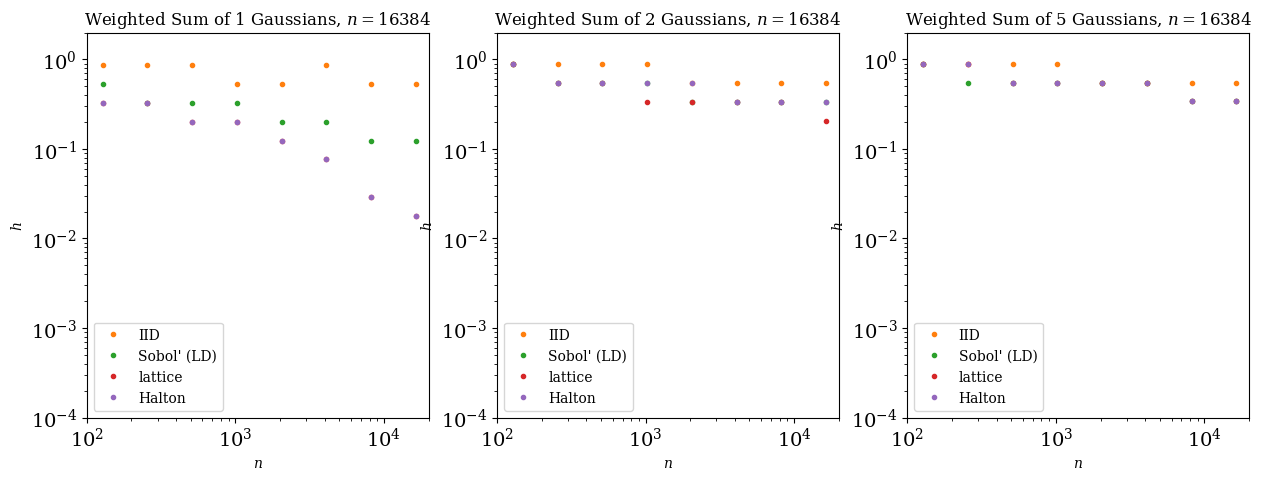

In [84]:
h_lim=[1e-4,2]
plot_kde_h_n(kernel_name,wh_err,ex_densities,n_list,dim_list,kde_err_out_dict,n_lim,h_lim)    #this function plots errors vs. the sample size

## Run numerical experiments and store the data

### Initialize parameters for the experiments

In [85]:
kernel = {"name" : "HermiteTwo", "bandwidth" : 1, "domain" : np.array([-np.inf,np.inf])}
nplot = 1507 #number of points to plot the KDE at
wh_err = "mae"

experiment_size = "large"
if experiment_size == "small":
    #small experiment
    n_rep = 5 #number of replications
    n_list = 2**np.arange(6,10,dtype=int)
else:
    #large experiment
    n_rep = 15 #number of replications
    n_list = 2**np.arange(7,15,dtype=int) #list of sample sizes

dens_kwargs = {"d" : 1, "coord_wts" : np.array(range(1,11))**-2.}
dim_list = np.array([1, 2, 5])
bandwidth_list = np.geomspace(1e-4,10,20)
n_densities = len(ex_densities)  #number of cases of f and densities
n_samplers = len(samplers)  #number of samplers
n_dim = dim_list.shape[0]  #number of dimensions
n_n = n_list.shape[0]  #number of sample sizes
n_bandwidth = bandwidth_list.shape[0]  #number of bandwidths
d_max = dim_list.max()
n_max = n_list.max()

## Initialize large arrays
rhoexact = np.zeros((n_densities,n_dim,nplot))
yplot = np.zeros((n_densities,n_dim,nplot))
kde_rhoapp = np.zeros((n_densities,n_samplers,n_dim,n_n,nplot))
kde_rhoapp_pp = np.zeros((n_rep,nplot))
kde_rhoapp_mm = np.zeros((n_bandwidth,nplot))
kde_err_out_dict = {(ii,jj,kk,ll) : 
        0 for ii in range(n_densities) for jj in range(n_samplers) for kk in range(n_dim) for ll in range(n_n)}
kde_err_out_dict_pp = {pp : 0 for pp in range(n_rep)}
kde_best_err_pp = np.zeros(n_rep)
cmc_rhoapp = np.zeros((n_densities,n_samplers,n_dim,n_n,nplot))
cmc_rhoapp_pp = np.zeros((n_rep,nplot))
cmc_err_out_dict = {(ii,jj,kk,ll) : 
        0 for ii in range(n_densities) for jj in range(n_samplers) for kk in range(n_dim) for ll in range(n_n)}
cmc_err_out_dict_pp = {pp : 0 for pp in range(n_rep)}
x_all = np.zeros((n_samplers,n_rep,n_max,d_max))   
ypts = np.zeros((n_rep,n_max))
kde_pp_wh_med = np.zeros((n_densities,n_samplers,n_dim,n_n))
kde_best_err = np.zeros((n_densities,n_samplers,n_dim,n_n))
kde_best_err_pp = np.zeros(n_rep)
cmc_pp_wh_med = np.zeros((n_densities,n_samplers,n_dim,n_n))
cmc_best_err = np.zeros((n_densities,n_samplers,n_dim,n_n))
cmc_best_err_pp = np.zeros(n_rep)

### Run the experiment (may take time)

In [86]:
def find_typical(wh_err,best_err_pp,err_out_dict_pp,rhoapp_pp): #find the typical results out of a number of replications
    pp_where = np.argsort(best_err_pp)[best_err_pp.shape[0]//2] #find the median error
    #print("pp_where = ",pp_where)
    return pp_where, best_err_pp[pp_where], err_out_dict_pp[pp_where], rhoapp_pp[pp_where,:]

In [ ]:
for jj in range(n_samplers):            # construct the IID and LD nodes
    for pp in range(n_rep):              # n_rep repetitions
        x_all[jj,pp,:,:] = samplers[jj]["gen_sample"](d_max,n_max) 
for ii in range(n_densities):  #iterate over different f and corresponding densities
    the_density = ex_densities[ii]  #this is the density that we are approximating
    for kk in range(n_dim):  #iterate over dimensions
        d = dim_list[kk]
        if (the_density["d_allowed"] == [np.inf]) or any(d == dd for dd in the_density["d_allowed"]):
            dens_kwargs["d"] = d  #update the dimension
            plt_domain = the_density["y_plt_domain"](**dens_kwargs) 
            #print(plt_domain)
            the_yplot = np.linspace(plt_domain[0],plt_domain[1],nplot)
            yplot[ii,kk,:] = the_yplot
            the_rhoexact = the_density["density"](the_yplot,**dens_kwargs)
            rhoexact[ii,kk,:] = the_rhoexact
            h_list = np.diff(plt_domain)[0]*bandwidth_list
            #print(h_list)
            #print(yplot[ii,kk,:])
            kernel["domain"] = the_density["y_domain"](**dens_kwargs)
            for jj in range(n_samplers):  #iterate over sampling methods
                print(f"density #{ii:.0f}, dimension = {d:.0f}, sampler #{jj:.0f}")
                for pp in range(n_rep):  #iterate over replications
                    ypts[pp,:] = the_density["f"](x_all[jj,pp,:,:d],**dens_kwargs)  #construct all data points for all repetitions                    
                for ll in range(n_n):  #iterate over sample sizes
                    n = n_list[ll]
                    for pp in range(n_rep):  #iterate over replications
                        #KDE experiment
                        for mm in range(n_bandwidth):  #iterate over different bandwidths 
                            kernel["bandwidth"] = h_list[mm]
                            kde_rhoapp_mm[mm,:] = kde(ypts[pp,:n],the_yplot,kernel)  #kde estimate for mm_th bandwidth and pp_th replication
                        #print("kde, n = ", n)
                        kde_err_out_dict_pp[pp] = error_rho(the_rhoexact,kde_rhoapp_mm,h_list,kind_of_err = [wh_err])  #optimize bandwidth
                        kde_best_err_pp[pp] = kde_err_out_dict_pp[pp][wh_err][2]
                        kde_rhoapp_pp[pp,:] = kde_rhoapp_mm[kde_err_out_dict_pp[pp][wh_err][0],:]
                        
                        #CMC experiment
                        if d > 1:
                            #print("n = ",n)
                            #print("x shape =",x_all[jj,pp,:n,:d].shape)
                            cmc_rhoapp_pp[pp,:] = cmc(the_density["gprime"],x_all[jj,pp,:n,:d],the_yplot,**dens_kwargs)  #cmc estimate
                            cmc_err_out_dict_pp[pp] = error_rho(the_rhoexact,cmc_rhoapp_pp[pp,:],np.array([1]),kind_of_err = [wh_err])  
                            cmc_best_err_pp[pp] = cmc_err_out_dict_pp[pp][wh_err][2]

                    #print(cmc_err_out_dict_pp)
                    #print(best_err)
                    #Find the typical results over the replications for kde
                    kde_pp_wh_med[ii,jj,kk,ll], kde_best_err[ii,jj,kk,ll], kde_err_out_dict[ii,jj,kk,ll], kde_rhoapp[ii,jj,kk,ll,:] = \
                        find_typical(wh_err,kde_best_err_pp,kde_err_out_dict_pp,kde_rhoapp_pp)
                    if d > 1:
                        cmc_pp_wh_med[ii,jj,kk,ll], cmc_best_err[ii,jj,kk,ll], cmc_err_out_dict[ii,jj,kk,ll], cmc_rhoapp[ii,jj,kk,ll,:] = \
                            find_typical(wh_err,cmc_best_err_pp,cmc_err_out_dict_pp,cmc_rhoapp_pp)


out_filename = f'KDE_Ex_Data_{wh_err:s}_{kernel["name"]:s}_nrep_{n_rep:.0f}_nmax_{n_max:.0f}_dmax_{d_max:.0f}.pkl'
stored_vars  = [wh_err,n_densities,n_dim,n_samplers,n_n,dim_list,n_list,yplot,rhoexact, \
                 kde_rhoapp,kde_err_out_dict,kde_pp_wh_med, kde_best_err, \
                 cmc_rhoapp,cmc_err_out_dict,cmc_pp_wh_med, cmc_best_err]
with open(figpath+out_filename,'wb') as myfile: 
    pickle.dump(stored_vars,myfile)  #save numerical output as a pickle file

print("finished")

density #0, dimension = 1, sampler #0
density #0, dimension = 1, sampler #1
density #0, dimension = 1, sampler #2
density #0, dimension = 1, sampler #3
density #0, dimension = 2, sampler #0
density #0, dimension = 2, sampler #1
density #0, dimension = 2, sampler #2
density #0, dimension = 2, sampler #3
density #0, dimension = 5, sampler #0
density #0, dimension = 5, sampler #1
density #0, dimension = 5, sampler #2
density #0, dimension = 5, sampler #3
density #1, dimension = 1, sampler #0
density #1, dimension = 1, sampler #1
density #1, dimension = 1, sampler #2
density #1, dimension = 1, sampler #3
density #1, dimension = 2, sampler #0
density #1, dimension = 2, sampler #1
density #1, dimension = 2, sampler #2
